### Libraries

In [1]:
import cooler
import cooltools
from cooltools.api.saddle import _make_cis_obsexp_fetcher
from cooltools.lib import numutils
from coolpuppy import coolpup
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup

import bioframe
import numpy as np
import pandas as pd
import bbi

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import multiprocessing

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


/home/carlos/miniconda3/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:651: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)
/home/carlos/miniconda3/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:726: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)


In [2]:
# set dpi for plots to 300
plt.rcParams['figure.dpi'] = 300

### Data Prep

In [4]:
NPROC = 8
#samples = ["t0", "t12"]
#samples = ["t12", "t30"]
#samples = ["t30", "t60"]
samples = ["t60", "t0"]

clrs_ = [
    cooler.Cooler(
        f"/home/carlos/Desktop/manuscripts/notebooks/matrices/{sample}_q30.mcool::resolutions/10000"
    )
    for sample in samples
]

In [5]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes("hg38")
hg38_cens = bioframe.fetch_centromeres("hg38")
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)

# Select only chromosomes that are present in the cooler.
hg38_arms = hg38_arms.set_index("chrom").loc[clrs_[0].chromnames].reset_index()

In [6]:
# import os.path
# if not os.path.exists("expected_t0.10000.csv"):
#     # intra-arm expected
#     expected_ = [
#         cooltools.expected_cis(
#             clr,
#             view_df=hg38_arms,
#             nproc=NPROC,
#         )
#         for clr in clrs_
#     ]

#     for sample, exp_df in zip(samples, expected_):
#         exp_df.to_csv(f"expected_{sample}.10000.csv", index=False)
# else:
#     expected_ = [
#         pd.read_csv(f"expected_{sample}.10000.csv")
#         for sample in samples
#     ]

In [7]:
expected_ = [
        cooltools.expected_cis(
            clr,
            view_df=hg38_arms,
            nproc=NPROC,
        )
        for clr in clrs_
    ]

In [8]:
# #res_path = "/home/carlos/Desktop/manuscripts/notebooks/gnn/results_t12_t30.tsv"
# #res_path = "/home/carlos/Desktop/manuscripts/notebooks/gnn/results_t12_t60.tsv"
# #res_path = "/home/carlos/Desktop/manuscripts/notebooks/gnn/results_t30_t60.tsv"
# res_path = "/home/carlos/Desktop/manuscripts/notebooks/gnn/results_t0_t30.tsv"

# #res_path = "/home/carlos/Desktop/manuscripts/notebooks/gnn/results_t0_t12.tsv"

# res = pd.read_csv(res_path, sep="\t")
# res = res.rename(columns={"chr": "chrom", "t0_q30-t30_q30": "t0_q30-t12_q30", "t30_q30-t0_q30": "t12_q30-t0_q30", "t0_q30-t30_q30-clf": "t0_q30-t12_q30-clf", "t30_q30-t0_q30-clf": "t12_q30-t0_q30-clf"})
# #res = res.rename(columns={"chr": "chrom", "t12_q30-t60_q30": "t0_q30-t12_q30", "t60_q30-t12_q30": "t12_q30-t0_q30", "t12_q30-t60_q30-clf": "t0_q30-t12_q30-clf", "t60_q30-t12_q30-clf": "t12_q30-t0_q30-clf"})
# #res = res.rename(columns={"chr": "chrom", "t12_q30-t30_q30": "t0_q30-t12_q30", "t30_q30-t12_q30": "t12_q30-t0_q30", "t12_q30-t30_q30-clf": "t0_q30-t12_q30-clf", "t30_q30-t12_q30-clf": "t12_q30-t0_q30-clf"})
# #res = res.rename(columns={"chr": "chrom", "t30_q30-t60_q30": "t0_q30-t12_q30", "t60_q30-t30_q30": "t12_q30-t0_q30", "t30_q30-t60_q30-clf": "t0_q30-t12_q30-clf", "t60_q30-t30_q30-clf": "t12_q30-t0_q30-clf"})
# res = res.dropna(subset=['t0_q30-t12_q30', 't12_q30-t0_q30'], inplace=False)
# res

In [9]:
res_path = "results.tsv"
res = pd.read_csv(res_path, sep="\t")
res = res.rename(columns={"chr": "chrom"})
res = res.dropna(subset=['t0_q30-t12_q30', 't12_q30-t0_q30'], inplace=False)
res

,chrom,start,end,name,t0_q30-t12_q30,t12_q30-t0_q30,t0_q30-t12_q30-clf,t12_q30-t0_q30-clf
101,chr1,1010000,1020000,chr1_p,4.553023,3.542044,0.0,0.0
102,chr1,1020000,1030000,chr1_p,3.359985,1.291808,0.0,0.0
103,chr1,1030000,1040000,chr1_p,10.071595,3.437320,0.0,0.0
105,chr1,1050000,1060000,chr1_p,16.551416,3.816790,0.0,0.0
106,chr1,1060000,1070000,chr1_p,7.490924,3.215562,0.0,0.0
...,...,...,...,...,...,...,...,...
303053,chrX,155220000,155230000,chrX_q,0.098888,0.003793,1.0,1.0
303054,chrX,155230000,155240000,chrX_q,0.000000,0.000000,1.0,1.0
303055,chrX,155240000,155250000,chrX_q,0.001021,0.058422,1.0,1.0
303056,chrX,155250000,155260000,chrX_q,0.131828,0.373975,1.0,0.0


In [10]:
comps = list(itertools.product([0,1], [0,1]))

In [11]:
for idx, (i1, i2) in enumerate(comps):
    df = res.loc[(res['t0_q30-t12_q30-clf'] == i1) & (res['t12_q30-t0_q30-clf'] == i2)]
    df.to_csv(f"t0_t12_results_{i1}_{i2}.tsv", sep="\t", index=False)

In [12]:
comps_sizes = []
for idx, (i1, i2) in enumerate(comps):
	current_comp_df = res.loc[(res['t0_q30-t12_q30-clf'] == i1) & (res['t12_q30-t0_q30-clf'] == i2)]
	print(
		i1, 
		i2, 
		len(current_comp_df), current_comp_df['t0_q30-t12_q30'].mean(), current_comp_df['t12_q30-t0_q30'].mean())
	comps_sizes.append(
		len(current_comp_df))

0 0 59975 2.63438216006572 2.049631556546057
0 1 45922 0.8560154546161083 0.015615034783487126
1 0 37424 0.02111715048594403 1.0874555960608954
1 1 124255 0.013222232264618338 0.008216861768490562


In [13]:
bins = clrs_[0].bins()[:]
total_genome_length = len(bins)
total_eval = 0
for size in comps_sizes:
    current_size_percent = size / total_genome_length * 100
    print(f"{current_size_percent:.2f}%")
    total_eval += current_size_percent

print(f"Total eval: {total_eval:.2f}%")

19.79%
15.15%
12.35%
40.99%
Total eval: 88.28%


### Insulation

In [ ]:
from cooltools import insulation

resolution = 10_000
windows = [50*resolution]

insulation_table_ = [
    insulation(clr, 
    windows, 
    verbose=False, 
    nproc = NPROC) 
    for clr in clrs_
    ]

In [ ]:
for i, table in enumerate(insulation_table_):
    df = table.iloc[:, [0,1,2,5]]
    bioframe.to_bigwig(df, hg38_chromsizes, f"insulation_{samples[i]}.bw")

In [ ]:
comps = list(itertools.product([0,1], [0,1]))
ins_array = [[] for l in range(2)]

flank = 1_000_000
nbins_ins = (flank // resolution) * 2 + 1
for idx, (i1, i2) in enumerate(comps):
    df = res.loc[(res['t0_q30-t12_q30-clf'] == i1) & (res['t12_q30-t0_q30-clf'] == i2)]
    # df = bioframe.ops.merge(df, 0)
    # df['start'] = df.apply(lambda x: x['start'] + (x['end'] - x['start']) // 2 - 5000, axis=1)
    # df['end'] = df['start'] + 10000
    # df['comp'] = f"{i1}-{i2}"

    ###
    #df = df.loc[merged_regions['n_intervals'] == 1]

    for l, bw in enumerate(["insulation_t0.bw", "insulation_t12.bw"]):
        stacked = bbi.stackup(
            bw,
            df.chrom,
            df.start - flank,
            df.end + flank,
            bins=nbins_ins,
        )
        ins_array[l].append(stacked)
            

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5), sharex=True, sharey=True)

# 0-1 scaling from sklearn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


for i in range(4):
    ax[i].set_title(f"{comps[i]}")
    ax[i].set_xlabel("bins")
    ax[i].set_ylabel("insulation")
    


    mean_arr_1 = scaler.fit_transform(np.nanmean(ins_array[0][i], axis=0).reshape(-1, 1)).reshape(-1)
    mean_arr_2 = scaler.fit_transform(np.nanmean(ins_array[1][i], axis=0).reshape(-1, 1)).reshape(-1)

    mean_arr_1 = np.nanmean(ins_array[0][i], axis=0)
    mean_arr_2 = np.nanmean(ins_array[1][i], axis=0)

    # mean_arr_1 = 2 ** (mean_arr_1)
    # mean_arr_2 = 2 ** (mean_arr_2)

    df_dict = {
        "Scaled Insulation": mean_arr_1.tolist() + mean_arr_2.tolist(),
        "bins": np.arange(nbins_ins).tolist() + np.arange(nbins_ins).tolist(),
        "sample": ["t0"]*nbins_ins + ["t12"]*nbins_ins
    }

    df = pd.DataFrame(df_dict)
    sns.lineplot(data=df, x="bins", y="Scaled Insulation", hue="sample", ax=ax[i])
    # add 2 vertical lines at n=75 and n=125
    ax[i].axvline(x=25, color='r', linestyle='--', alpha=0.75)
    ax[i].axvline(x=75, color='r', linestyle='--', alpha=0.75)

    if i != 3:
        ax[i].get_legend().remove()


In [ ]:
# test ins score

table_i = 0

df = insulation_table_[table_i]

scores = df.log2_insulation_score_500000
q = 20

flank_ins = 500_000

df['quartiles'] = pd.qcut(scores, q=q, labels=[f'Q{i+1}' for i in range(q)])
df['start'] -= flank_ins
df['end'] += flank_ins
piles = []
for q_val in ['Q1', 'Q19']:
    df_curr = df.loc[df['quartiles'] == q_val]
    df_curr = df_curr[['chrom', 'start', 'end']]
    df_curr = df_curr.sample(n=100, random_state=42)
    for i in range(2):
        pile = coolpup.pileup(clrs_[i], df_curr, features_format='bed', view_df=hg38_arms, expected_df=expected_[i], nproc=NPROC, local=True, flank=flank_ins)
        piles.append(pile)

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5), sharex=True, sharey=True)
ax_i = 0

for pile in piles: 
        sns.heatmap(pile.data[0], ax=ax[ax_i])
        ax_i += 1

### Viz Regions

In [ ]:
from matplotlib.ticker import EngFormatter
import matplotlib.patches as patches

bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

def get_OE(region, oe_mtx, resolution=10_000):
    bins_start, bins_end = region[1]//resolution, region[2]//resolution
    return oe_mtx[bins_start:bins_end, bins_start:bins_end]

from matplotlib.colors import LogNorm

def viz_region(region, clrs, mainMtx, ax=None, resolution=10_000):
    norm = LogNorm(vmin=1e-1, vmax=1e2)
    mtx1, mtx2 = get_OE(region, mainMtx[0], resolution=resolution), get_OE(region, mainMtx[1], resolution=resolution)

    # remove lower triangular from mtx1 and upper triangular from mtx2
    mtx1 = np.triu(mtx1, 1)
    mtx2 = np.tril(mtx2, -1)

    hm = sns.heatmap(mtx1+mtx2, cmap="vlag", ax=ax, norm=norm)
    rect = patches.Rectangle((74, 74), 51, 51, linewidth=2, edgecolor='black', facecolor='none')
    hm.add_patch(rect)

# generate region fetcher functions
getmatrix_ = [
    _make_cis_obsexp_fetcher(
        clrs_[i],
        expected_[i],
        hg38_arms,
    )
    for i, _ in enumerate(samples)
]

In [ ]:
piles_ = []
comps = list(itertools.product([0,1], [0,1]))

merged_regions_df_ = []
for idx, (i1, i2) in enumerate(comps):
    df = res.loc[(res['t0_q30-t12_q30-clf'] == i1) & (res['t12_q30-t0_q30-clf'] == i2)]
    merged_regions = bioframe.ops.merge(df, 0)
    merged_regions['start'] = merged_regions.apply(lambda x: x['start'] + (x['end'] - x['start']) // 2 - 5000, axis=1)
    merged_regions['end'] = merged_regions['start'] + 10000
    merged_regions['comp'] = f"{i1}-{i2}"
    merged_regions_df_.append(merged_regions)
merged_regions_df = pd.concat(merged_regions_df_)

In [ ]:
# set dpi

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [ ]:
flank = 1_000_000
n = 10
arm = "chr1_p"
fig, ax = plt.subplots(4, ncols=n, figsize=(n*8, n*4))


from cooltools.lib import numutils
def fill_diag(minD, maxD, matrix):
    for d in np.arange(-minD + 1, minD):
            numutils.set_diag(matrix, np.nan, d)
    if maxD >= 0:
        for d in np.append(
            np.arange(-matrix.shape[0], -maxD),
            np.arange(maxD + 1, matrix.shape[0]),
        ):
            numutils.set_diag(matrix, np.nan, d)



for l, (i1, i2) in enumerate(list(itertools.product([0,1], [0,1]))):
    res_f = res.dropna(subset=['t0_q30-t12_q30', 't12_q30-t0_q30'], inplace=False)
    df = res_f.loc[
        (res_f['t0_q30-t12_q30-clf'] == i1) &
        (res_f['t12_q30-t0_q30-clf'] == i2) & 
        (res_f['name'] == arm)
        ].reset_index(drop=True)

    df = df.sample(n)
    print(df)
    piles = []
    for i in range(2):
        pile = cooltools.pileup(clrs_[i], df, view_df = hg38_arms, expected_df = expected_[i], nproc=1, flank=flank)
        piles.append(pile)

    mtx1 = piles[0]
    mtx2 = piles[1]
    for i in range(n):
        fill_diag(2, -1, mtx1[:,:,i])
        fill_diag(2, -1, mtx2[:,:,i])

        # m_1 = np.triu(mtx1[:,:,i], 1)
        # m_2 = np.tril(mtx2[:,:,i], -1)
        # m = m_1 + m_2

        m = mtx2[:,:,i] / mtx2[:,:,i]
        hm = sns.heatmap(m, cmap="vlag", ax=ax[l, i])
        
        #hm = sns.heatmap(m, cmap="vlag", ax=ax[l, i], norm=LogNorm(vmin=1e-1, vmax=1e1))
        rect = patches.Rectangle((74, 74), 51, 51, linewidth=2, edgecolor='black', facecolor='none')
        hm.add_patch(rect)

In [ ]:
df = merged_regions_df.loc[(merged_regions_df['comp'] == '1-0') & (merged_regions_df['chrom'] == 'chr1')].reset_index(drop=True)
flank = 500_000
pl_ = []
for i in range(2):
    pl_.append(cooltools.pileup(clrs_[i], df, expected_df = expected_[i], view_df=hg38_arms, nproc=NPROC, flank=flank))
    
from cooltools.lib import numutils
def fill_diag(minD, maxD, matrix):
    for d in np.arange(-minD + 1, minD):
            numutils.set_diag(matrix, np.nan, d)
    if maxD >= 0:
        for d in np.append(
            np.arange(-matrix.shape[0], -maxD),
            np.arange(maxD + 1, matrix.shape[0]),
        ):
            numutils.set_diag(matrix, np.nan, d)

fig, ax = plt.subplots(ncols=2, figsize=(18, 10))
mtx1, mtx2 = pl_[0], pl_[1]
mtx1 = np.nanmean(mtx1, axis=2)
mtx2 = np.nanmean(mtx2, axis=2)

fill_diag(2, -1, mtx1)
fill_diag(2, -1, mtx2)

cmp=sns.color_palette("vlag", as_cmap=True)

sns.heatmap(mtx1, ax = ax[0], cmap=cmp)
sns.heatmap(mtx2, ax = ax[1], cmap=cmp)


### Wrapping regions

In [ ]:
regs_ = []
comps = [(0,0),(0,1), (1,0), (1,1)]

filter_for_highest_quartile = True

for idx, (i1, i2) in enumerate(comps):
    df = res.loc[(res['t0_q30-t12_q30-clf'] == i1) & (res['t12_q30-t0_q30-clf'] == i2)]

    if filter_for_highest_quartile:
        if i1 == 0:
            df = df.loc[df['t0_q30-t12_q30'] > df['t0_q30-t12_q30'].quantile(0.75)]
        if i2 == 0:
            df = df.loc[df['t12_q30-t0_q30'] > df['t12_q30-t0_q30'].quantile(0.75)]

    # df = bioframe.ops.merge(df, 0)
    # df['start'] = df.apply(lambda x: x['start'] + ((x['end'] - x['start']) // 2 - 5000), axis=1)
    # df['end'] = df['start'] // 10000 * 10000 + 10000
    df['comp'] = f"{i1}-{i2}"
    regs_.append(df)
all_regs = pd.concat(regs_)

In [ ]:
def closest_reg(df1, df2, flank=1_000_000):

    k = flank * 2 // 10000 
    closest_df = bioframe.closest(df1, df2, suffixes=("_1", "_2"), k=k)
    closest_df['distance'] += 10000
    closest_df['distance'] = closest_df.apply(lambda x: -1 * x['distance'] if x['start_1'] > x['start_2'] else x['distance'], axis=1) 
    closest_df = closest_df.loc[np.abs(closest_df['distance']) < flank]
    return closest_df

def _rnd_regions(bins_df, n):
    return bins_df[bins_df.weight > 0].sample(n=n, random_state=42)

In [ ]:
import multiprocessing as mp

df_comps = []
for i in range(4):
    for j in range(4):
        if i == j:
            continue
        df_comps.append((regs_[i], regs_[j]))

pool = mp.Pool(8)
closest_ = pool.starmap(closest_reg, df_comps)
pool.close()

In [ ]:
bins = clrs_[0].bins()[:]
df_comps = []
for i in range(4):
        n = len(regs_[i])
        rng =  _rnd_regions(bins, n)
        rng = bioframe.setdiff(rng, regs_[0])
        df_comps.append((regs_[i], rng))
pool = mp.Pool(4)
closest_exp = pool.starmap(closest_reg, df_comps)
pool.close()

In [ ]:
df1, df2 = closest_reg(regs_[1], regs_[2], flank = 250_000), closest_reg(regs_[2], regs_[1], flank = 250_000)

In [ ]:
df1.sort_values(by=['distance']).hist(column='distance', bins=50)

In [ ]:
df2.sort_values(by=['distance']).hist(column='distance', bins=50)

In [ ]:
def _plot_closest(closest_df, closest_exp=None):
    fig, ax = plt.subplots(1, 4, figsize=(20, 8), sharex=True, sharey=True)
    l = 0
    for i in range(4):
        df_comps = []
        for j in range(4):
            if i == j:
                continue

            plot_dict = {}
            data = closest_df[l]['distance']
            l+=1
            plot_dict[f"data"] = data
            plot_dict[f"comp"] = f"vs-{comps[j]}"
            data = pd.DataFrame(plot_dict)
            df_comps.append(data)

        # rnd = closest_exp[i]
        # plot_dict_exp = {}
        # data = rnd['distance']
        # plot_dict_exp[f"data"] = data
        # plot_dict_exp[f"comp"] = f"rnd-{comps[j]}"
        # df_comps.append(pd.DataFrame(plot_dict_exp))

        data_df = pd.concat(df_comps)
        kde = sns.histplot(data=data_df, x="data", hue="comp", ax = ax[i], stat="probability", common_norm=False, bins=25, fill=True, palette=['red', 'green', 'blue'], kde=True)
        kde.set_title(f"Centered at {comps[i]}")

_plot_closest(closest_)

In [ ]:
boundaries = [pd.read_csv(f"/cta/users/vkaya/hi-c/work/hela/notebooks/boundaries/{sample_name}_boundaries.csv") for sample_name in ["Control", "12min"]]

In [ ]:
def closest_reg_boundaries(df1, df2, flank=250_000):

    k = flank * 2 // 10000 
    closest_df = bioframe.closest(df1, df2, suffixes=("_1", "_2"), k=k, ignore_overlaps=True)
    closest_df['distance'] = closest_df.apply(lambda x: -1 * x['distance'] if x['start_1'] > x['start_2'] else x['distance'], axis=1) 
    return closest_df.loc[np.abs(closest_df['distance']) <= flank]



df_comps = []
piles_ = []
for boundaries_df in boundaries:
    boundaries_df = boundaries_df.loc[(boundaries_df.boundary_strength_500000 > 0) & (boundaries_df.is_boundary_500000 == True)]
    boundaries_df = boundaries_df.loc[(boundaries_df.is_bad_bin == False)] 
#     quartiles = pd.qcut(boundaries_df.boundary_strength_500000, q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
#     boundaries_df['quartiles'] = quartiles
#     boundaries_df = boundaries_df.loc[boundaries_df['quartiles'] == 'Q1']
#     piles_.append([coolpup.pileup(clr, boundaries_df, 
#                     features_format='bed', view_df=hg38_arms, 
#                     expected_df=expected, 
#                     nproc=NPROC, local=True, flank=500_000)
#                                 for clr, expected in zip(clrs_, expected_)])
    for i in range(4):
        df_comps.append((regs_[i], boundaries_df))
        #df_comps.append((boundaries_df, regs_[i]))

import multiprocessing as mp
pool = mp.Pool(8)
boundaries_comp_ = pool.starmap(closest_reg_boundaries, df_comps)
pool.close()

In [ ]:
boundaries_df = boundaries[0]
boundaries_df = boundaries_df.loc[(boundaries_df.boundary_strength_500000 > 0) & (boundaries_df.is_boundary_500000 == True)]
boundaries_df = boundaries_df.loc[(boundaries_df.is_bad_bin == False)]

piles_ = []
for i in range(4):
    regions = bioframe.overlap(boundaries_df, regs_[i], suffixes=("_1", "_2"), how="inner")
    regions = regions[['chrom_1', 'start_1', 'end_1']]
    regions = regions.rename(columns={"chrom_1": "chrom", "start_1": "start", "end_1": "end"})
    piles_.append([coolpup.pileup(clr, regions, 
                    features_format='bed', view_df=hg38_arms, 
                    expected_df=expected, 
                    nproc=NPROC, local=True, flank=500_000) for clr, expected in zip(clrs_, expected_)])

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 8), sharex=True, sharey=True)
divides_ = []
for i in range(4):
    divides_.append(divide_pups(piles_[i][1], piles_[i][0]))

data = [np.log2(divides_[i].data[0]) for i in range(4)]
vmin = np.nanmin([np.nanmin(data[i]) for i in range(4)])
vmax = np.nanmax([np.nanmax(data[i]) for i in range(4)])
for i in range(4):
    print(divides_[i].n / 2)
    sns.heatmap(data[i], ax=ax[i], cmap="vlag", vmin=vmin, vmax=vmax, center=0)

In [ ]:
control = boundaries_comp_[:4]
t12 = boundaries_comp_[4:]

In [ ]:
df_ = []
for i in range(4):
    df_dict = {}
    data = control[i]['distance']
    df_dict[f"data"] = data
    df_dict[f"comp"] = f"vs-{comps[i]}"
    data = pd.DataFrame(df_dict)
    df_.append(data)

data_df = pd.concat(df_)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(data=data_df, x="data", hue="comp", fill=False, kde=True, ax=ax, palette=['red', 'green', 'blue', 'purple'],
stat="percent", common_norm=False, bins=200)

In [ ]:
def make_tads(insul_df, maxlen=1_500_000):
        tads = (
        insul_df.groupby("chrom")
        .apply(
            lambda x: pd.concat(
                [x[:-1].reset_index(drop=True), x[1:].reset_index(drop=True)],
                axis=1,
                ignore_index=True,
            )
        )
        .reset_index(drop=True)
        )
        tads.columns = [["chrom1", "start1", "end1", "chrom2", "start2", "end2"]]
        tads.columns = tads.columns.get_level_values(0)
        tads = tads[
            (tads["start2"] - tads["start1"]) <= maxlen
        ].reset_index(drop=True)
        tads["start"] = (tads["start1"] + tads["end1"]) // 2
        tads["end"] = (tads["start2"] + tads["end2"]) // 2
        tads = tads[["chrom1", "start", "end"]]
        tads.columns = ['chrom', 'start', 'end']
        return tads

df = boundaries[0]
df = df.loc[(df.is_bad_bin == False)]
df = df.loc[(df.boundary_strength_500000 > 0) & (df.is_boundary_500000 == True)]
tads = make_tads(df.iloc[:, [0,1,2]])
boundaries_new = tads.copy()
boundaries_new.end = boundaries_new.start + 10000

### Regions & Heatmaps

In [14]:
flank = 500_000
import itertools
piles_ = []
comps = list(itertools.product([0,1], [0,1]))

filter_for_highest_quartile = False
merge_regions = True

regions_df_ = []
for idx, (i1, i2) in enumerate(comps):
    df = res.loc[(res['t0_q30-t12_q30-clf'] == i1) & (res['t12_q30-t0_q30-clf'] == i2)].copy()

    if filter_for_highest_quartile:
        if i1 == 0:
            df = df.loc[df['t0_q30-t12_q30'] > df['t0_q30-t12_q30'].quantile(0.75)]
        if i2 == 0:
            df = df.loc[df['t12_q30-t0_q30'] > df['t12_q30-t0_q30'].quantile(0.75)]

    if merge_regions:
        merged_regions = bioframe.ops.merge(df, 0)
        merged_regions['start'] = merged_regions.apply(lambda x: x['start'] + (x['end'] - x['start']) // 2 - 5000, axis=1)
        merged_regions['end'] = merged_regions['start'] + 10000
        merged_regions['comp'] = f"{i1}-{i2}"
        regions_df_.append(merged_regions)
        piles_.append([coolpup.pileup(clr, merged_regions, 
                        features_format='bed', view_df=hg38_arms, expected_df=expected, nproc=NPROC, local=True, flank=flank)
                                    for clr, expected in zip(clrs_, expected_)])
    else:
        df['comp'] = f"{i1}-{i2}"
        regions_df_.append(df)
        piles_.append([coolpup.pileup(clr, df, 
                        features_format='bed', view_df=hg38_arms, expected_df=expected, nproc=NPROC, local=True, flank=flank)
                                    for clr, expected in zip(clrs_, expected_)])

regions_df = pd.concat(regions_df_)

INFO:coolpuppy:('chr4_p', 'chr4_p'): 337
INFO:coolpuppy:('chr2_p', 'chr2_p'): 722
INFO:coolpuppy:('chr1_p', 'chr1_p'): 845
INFO:coolpuppy:('chr3_p', 'chr3_p'): 509
INFO:coolpuppy:('chr5_p', 'chr5_p'): 190
INFO:coolpuppy:('chr6_p', 'chr6_p'): 376
INFO:coolpuppy:('chr4_q', 'chr4_q'): 643
INFO:coolpuppy:('chr8_p', 'chr8_p'): 287
INFO:coolpuppy:('chr7_p', 'chr7_p'): 405
INFO:coolpuppy:('chr3_q', 'chr3_q'): 742
INFO:coolpuppy:('chr2_q', 'chr2_q'): 1157
INFO:coolpuppy:('chr9_p', 'chr9_p'): 237
INFO:coolpuppy:('chr10_p', 'chr10_p'): 284
INFO:coolpuppy:('chr1_q', 'chr1_q'): 754
INFO:coolpuppy:('chr5_q', 'chr5_q'): 852
INFO:coolpuppy:('chr6_q', 'chr6_q'): 750
INFO:coolpuppy:('chr11_p', 'chr11_p'): 272
INFO:coolpuppy:('chr7_q', 'chr7_q'): 690
INFO:coolpuppy:('chr8_q', 'chr8_q'): 693
INFO:coolpuppy:('chr12_p', 'chr12_p'): 242
INFO:coolpuppy:('chr9_q', 'chr9_q'): 613
INFO:coolpuppy:('chr10_q', 'chr10_q'): 716
INFO:coolpuppy:('chr17_p', 'chr17_p'): 142
INFO:coolpuppy:('chr16_p', 'chr16_p'): 178
INF

In [15]:
# analyze percent merged regions bins to whole genome bins
total_bins_in_genome = bins.shape[0]
for i1, i2 in comps:
    print(i1, i2, len(regions_df.loc[(regions_df['comp'] == f"{i1}-{i2}")]), f"Percent of genome: {len(regions_df.loc[(regions_df['comp'] == f'{i1}-{i2}')]) / total_bins_in_genome * 100:.2f}%")

0 0 18666 Percent of genome: 6.16%
0 1 20530 Percent of genome: 6.77%
1 0 15356 Percent of genome: 5.07%
1 1 25782 Percent of genome: 8.51%


[0, 1]
[2, 3]
[4, 5]
[6, 7]


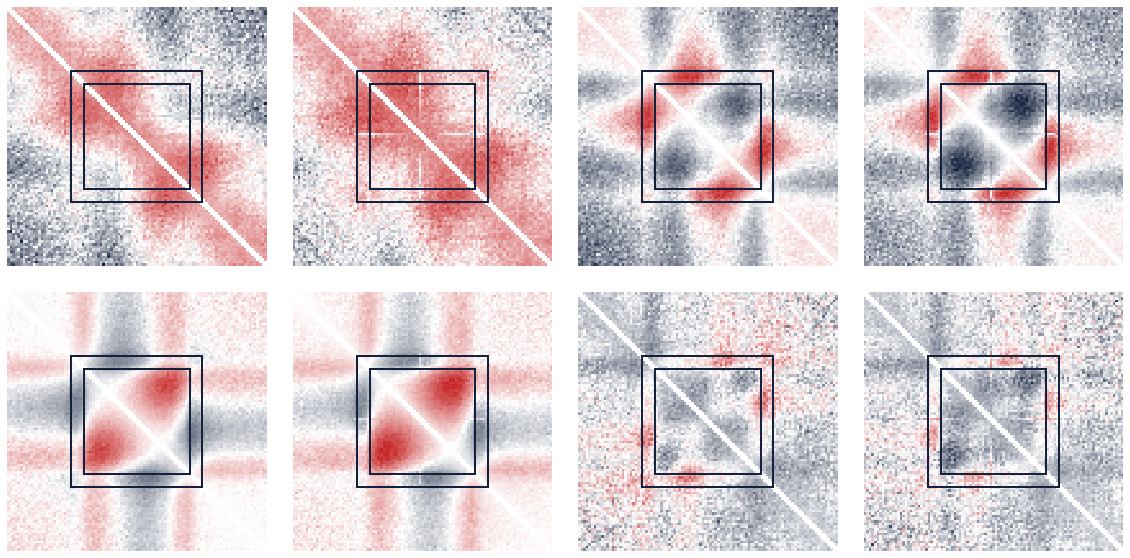

In [16]:
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

cmp = LinearSegmentedColormap.from_list("custom_cmp", ["#14213D", "white", "#C42021"], N=256)

log2ss = "$log_{2}$"

piles_all_ = [pup.data[0] for pile in piles_ for pup in pile ]
fig, ax = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

v_min_all = np.nanmin(np.concatenate(piles_all_))
v_max_all = np.nanmax(np.concatenate(piles_all_))

v_idx_ = [[i,i+1] for i in range(0, 8, 2)]
v_mins = []
v_maxs = []
for v_idx in v_idx_:
    print(v_idx)
    i1, i2 = v_idx
    arr1, arr2 = piles_all_[i1], piles_all_[i2]
    v_min = np.nanmin(np.concatenate([arr1, arr2]))
    v_max = np.nanmax(np.concatenate([arr1, arr2]))
    v_mins += [v_min, v_min]
    v_maxs += [v_max, v_max]

comps_names = ["t0 vs t12", "t12 vs t0"]

comps_labes = [[f"{comps_names[i1]}: {i1}\n{comps_names[i2]}: {i2}"]*2 for i1, i2 in comps]
comps_labes = [i for i in comps_labes for i in i]

for i, pup in enumerate(piles_all_):
    

    #sns.heatmap(pup, cmap=cmp, vmin=v_min_all, vmax=v_max_all, ax=ax[i//4, i%4], center=1, cbar=True)
    sns.heatmap(pup, cmap=cmp, vmin=v_mins[i], vmax=v_maxs[i], ax=ax[i//4, i%4], cbar=False, center=1)
    #sns.heatmap(pup, cmap=cmp, ax=ax[i//4, i%4], cbar=True)
    rect = patches.Rectangle((30, 30), 41, 41, linewidth=2, edgecolor='#14213D', facecolor='none', alpha=1)
    ax[i//4, i%4].add_patch(rect)
    rect = patches.Rectangle((25, 25), 51, 51, linewidth=2, edgecolor='#14213D', facecolor='none', alpha=1)
    ax[i//4, i%4].add_patch(rect)

    # remove yticks, xtiks, xlabel, ylabel
    ax[i//4, i%4].set_yticks([])
    ax[i//4, i%4].set_xticks([])

    # xlabel = f"{comps_labes[i]}" 
    # ax[i//4, i%4].set_xlabel(xlabel)
    
    ax[i//4, i%4].set_ylabel("")

    # set fontsize of xlabel and ylabel
    ax[i//4, i%4].xaxis.label.set_size(20)
    ax[i//4, i%4].yaxis.label.set_size(20)

    # set fontsize of ticks of cbar
    #ax[i//4, i%4].collections[0].colorbar.ax.tick_params(labelsize=20)

# fig.savefig("gnn_pup_all_t0vst12.png", dpi=600, bbox_inches='tight')
# fig.savefig("gnn_pup_all_t0vst12.svg", bbox_inches='tight')

In [17]:
def create_colorbar(vmin_value, vmax_value, cmap, ax=None, orientation='vertical'):

    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin_value, vmax=vmax_value)),
                        orientation=orientation, cax=ax,)

    if orientation == 'horizontal':
        ax.set_yticks([])
        ax.set_xticks([vmin_value, vmax_value])
        cbar.ax.tick_params(labelsize=16)

    elif orientation == 'vertical':
        ax.set_xticks([])
        ax.set_yticks([vmin_value, vmax_value])
        cbar.ax.tick_params(labelsize=16)

    plt.xticks(rotation=45, ha='right')

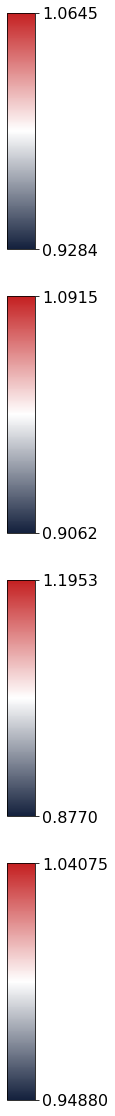

In [18]:
orientation = 'vertical'
w = .5
h = 20
fig, ax = plt.subplots(4, 1, figsize=(w, h),)# gridspec_kw={'hspace': 1, 'wspace': 1})

for i, l in enumerate(range(0, 8, 2)):
    vmin, vmax = v_mins[l], v_maxs[l]
    create_colorbar(vmin_value=vmin, vmax_value=vmax, cmap = cmp, ax = ax[i], orientation=orientation)

# fig.savefig("gnn_pup_all_cbar_t0vst12.png", dpi=1200, bbox_inches='tight')
# fig.savefig("gnn_pup_all_cbar_t0vst12.svg", bbox_inches='tight')


## Regions Change

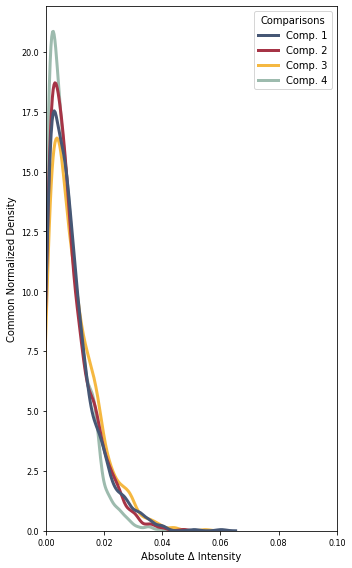

In [78]:
piles_divide_ = [np.log2(tup[1].data[0] / tup[0].data[0]) for tup in piles_]
piles_divide_ = [np.abs(pup) for pup in piles_divide_]
changes_ = [pup[25:76, 25:76].flatten() for pup in piles_divide_]

comps_labels = [f"Comp{i}" for i in range(1,5)]
changes_dict = {
    k:list(v[~np.isnan(v)]) for k, v in zip(["Comp. 1", "Comp. 2", "Comp. 3", "Comp. 4"], changes_)
}
plot_dict = {
    "Comparisons": [],
    "Changes": []
}
for k, v in changes_dict.items():
    plot_dict["Comparisons"] += [k] * len(v)
    plot_dict["Changes"] += v
plot_df = pd.DataFrame(plot_dict)

fig, ax = plt.subplots(1, 1, figsize=(5, 8))

s = sns.kdeplot(data = plot_df, x="Changes", hue="Comparisons", fill=False, palette = ['#465775', '#A63446', '#F5B841', '#9DBBAE'], ax = ax, alpha=1, common_norm=True, linewidth=3)
s.tick_params(axis='both', which='major', labelsize=8)
s.tick_params(axis='both', which='minor', labelsize=8)
s.set_xlabel(u"Absolute Δ Intensity", fontsize=10)
s.set_ylabel(u"Common Normalized Density", fontsize=10)

s.set_xlim(0, .1)

plt.tight_layout()
# fig.savefig("regions_change_density_t0vst12.png", dpi=600, bbox_inches='tight')
# fig.savefig("regions_change_density_t0vst12.svg", bbox_inches='tight')

In [79]:
#plot_df.to_csv("regions_change_density_t0vst12.tsv", index=False, sep="\t")

## Repair Data

In [19]:
import bbi
chrom_sizes = bioframe.fetch_chromsizes("hg38")[:23]
def get_mean_bw(bw, chrom_sizes):
    for chrom in chrom_sizes.index:
        start, end = 0, chrom_sizes.loc[chrom] // 10000 * 10000
        yield np.nanmean(bbi.fetch(bw, chrom, start, end, bins=chrom_sizes.loc[chrom] // 1000))

BWS = {
    'xr-64-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_64_real_over_sim_res1000.bw',
    'xr-cpd-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_CPD_real_over_sim_res1000.bw',
    'ds-64-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/DS_64_real_over_sim_res1000.bw',
    'ds-cpd-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/DS_CPD_real_over_sim_res1000.bw',
    'rep-eff-64': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_64_rep_eff_res1000.bw',
    'rep-eff-cpd': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_CPD_rep_eff_res1000.bw',
    }

MEANS_BW = {}
for k in BWS:
    curr_mean = np.mean(list(get_mean_bw(BWS[k], chrom_sizes)))
    MEANS_BW[k] = curr_mean
    print("Mean", k, curr_mean)

interval_size = 1000
bws_per_key = {}
mean_norm = True
for k in BWS.keys():
    per_chr = []
    for chrName in chrom_sizes.index:
        chrLen = chrom_sizes.loc[chrName]
        start, end = 0, chrLen // interval_size * interval_size
        n_bins = end // interval_size
        arr_chr = bbi.fetch(
            BWS[k],
            chrName,
            start,
            end,
            bins=n_bins,
        )
        per_chr.append(arr_chr / MEANS_BW[k]) if mean_norm else per_chr.append(arr_chr)
    bws_per_key[k] = per_chr

Mean xr-64-over-sim 1.1196280573820672
Mean xr-cpd-over-sim 1.1868305407819189
Mean ds-64-over-sim 1.23405186005681
Mean ds-cpd-over-sim 1.2698717973554339
Mean rep-eff-64 1.482119054797605
Mean rep-eff-cpd 1.567885930820114


In [20]:
def region_per_df_wrapper(df, arr_k_dict, total_intervals, interval_size=1000, flank=500_000):
    regions = []
    for i, row in df.iterrows():
        chrom, start, end = row['chrom'], row['start'], row['end']
        chrom_idx = chrom_sizes.index.get_loc(chrom)
        start, end = start - flank, end + flank

        curr_arr = arr_k_dict[chrom_idx][start//interval_size:end//interval_size]
        if len(curr_arr) != total_intervals: # filter out regions that exceed the chromosome length
            continue
        if len(np.where(curr_arr == np.nan)[0]) >= len(curr_arr * 10 / 100):
            print("nan")
            continue
        regions.append(curr_arr)

    return np.array(regions)

flank = 500_000
total_intervals = (2 * flank + 10_000) // interval_size
n_bins = total_intervals

args = []
for comp_idx, (i1, i2) in enumerate(comps):
    curr_df = regions_df.loc[(regions_df['comp'] == f"{i1}-{i2}")]
    for k in BWS.keys():
        args.append((curr_df, bws_per_key[k], total_intervals, interval_size, flank))

import tqdm
with multiprocessing.Pool(NPROC) as pool:
    results = pool.starmap(region_per_df_wrapper, tqdm.tqdm(args, total=len(args)))
    pool.close()

100%|██████████| 24/24 [00:06<00:00,  3.89it/s]


In [21]:
bw_dict_all = [{} for i in range(len(comps))]
for comp_idx, (i1, i2) in enumerate(comps):
    for k in BWS.keys():
        bw_dict_all[comp_idx][k] = results[comp_idx*len(BWS.keys()) + list(BWS.keys()).index(k)]

In [22]:
from scipy.ndimage import gaussian_filter1d

def make_bw_df(bw_dict, sigma=None):
    bw_data = {
    'n': [],
    'val': [],
    'name': []
    }

    for i, k in enumerate(bw_dict.keys()):
        arr = np.array(bw_dict[k])

        mean_val = np.nanmean(arr, axis=0)
        val = gaussian_filter1d(mean_val, sigma = sigma) if sigma != None else mean_val

        bw_data['n'].extend(np.arange(len(val)).tolist())
        bw_data['val'].extend(val)
        bw_data['name'].extend([k] * len(val))

    return pd.DataFrame(bw_data)

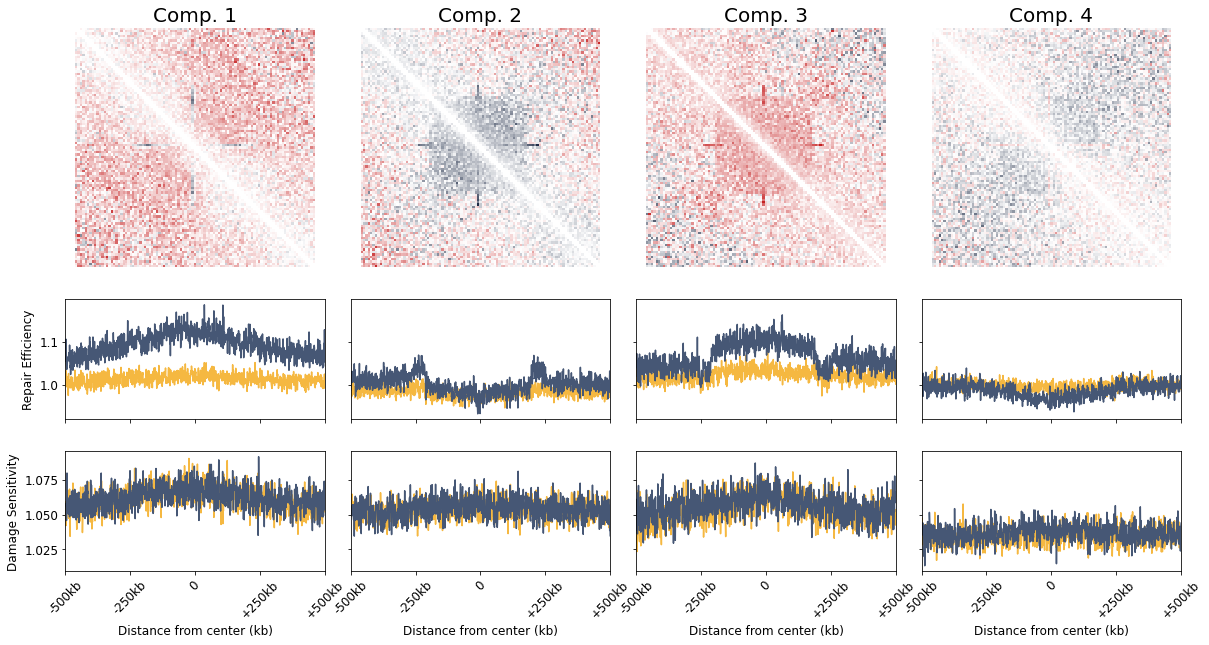

In [23]:
sigma = None

keys_row = {
    0: ['rep-eff-64', 'rep-eff-cpd'],
    #0: ['xr-64-over-sim', 'xr-cpd-over-sim'],
    1: ['ds-64-over-sim', 'ds-cpd-over-sim'],
}

row_names = {
    0: "Repair Efficiency",
    #0: "Normalized Repair levels",
    1: "Damage Sensitivity",
}

fig, ax = plt.subplots(
    len(keys_row)+1, 4,
    figsize=(20, 10), 
    sharex="row", sharey="row",
    # make ratios
    gridspec_kw={'height_ratios': [.5, .25, .25], 'hspace': 0.2, 'wspace': 0.1},
)

piles_divide_ = [np.log2(tup[1].data[0] / tup[0].data[0]) for tup in piles_]
#piles_divide_ = [tup[1].data[0] / tup[0].data[0] for tup in piles_]


v_min_hm = np.nanmin(np.concatenate(piles_divide_))
v_max_hm = np.nanmax(np.concatenate(piles_divide_))

oe_ss = "$ _{OE}$"

comp_names_easy = ["Comp. 1", "Comp. 2", "Comp. 3", "Comp. 4"]

comps_labes_now = [comps_labes[i] for i in range(0,8,2)]

cmp = LinearSegmentedColormap.from_list("custom_cmp", ["#14213D", "white", "#C42021"], N=256)
for i, pup in enumerate(piles_divide_):

    # continue # do not plot the heatmap

    ax_now = ax[0,i]
    # pup = pup[25:76, 25:76] # zoom in
    sns.heatmap(pup, cmap=cmp, vmin=v_min_hm, vmax=v_max_hm, ax=ax_now, cbar=False, square=True, xticklabels=False, yticklabels=False, center=0)
    # rect = patches.Rectangle((25, 25), 51, 51, linewidth=2, edgecolor='black', facecolor='none')
    # ax_now.add_patch(rect)
    # rect = patches.Rectangle((30, 30), 41, 41, linewidth=2, edgecolor='black', facecolor='none')
    # ax_now.add_patch(rect)
    ax_now.set_title(f"{comp_names_easy[i]}", fontsize=20)


for i, l in enumerate(bw_dict_all):    
    for k in range(len(keys_row)):
        
        ax_now = ax[k+1,i]
        
        l_now = {
            k_now: l[k_now] for k_now in keys_row[k]
        }

        armlabel=flank//1000
        
        bw_df = make_bw_df(l_now, sigma = sigma)

        lp = sns.lineplot(
            data=bw_df,
                x='n', 
                y='val',
                hue='name', 
                ax=ax_now,
                legend=True,
                #alpha=0.6,
                palette = ['#F5B841', '#465775'])
        
        end = bw_df['n'].max()
        lp.set_xticks([0, end//4, end//2, end//4*3, end])
        lp.set_ylabel(f"{row_names[k]}", fontsize=12)

        if k!=len(keys_row)-1:
            lp.set_xticklabels([])
            lp.set_xlabel("")
        else:
            lp.set_xticklabels([f"-{armlabel}kb", f"-{armlabel//2}kb", 0, f"+{armlabel//2}kb", f"+{armlabel}kb"], fontsize=12)
            lp.set_xlabel("Distance from center (kb)", fontsize=12)
            # rotate xlabels
            for tick in lp.get_xticklabels():
                tick.set_rotation(45)

        ax_now.get_legend().remove()

        ax_now.tick_params(axis='both', which='major', labelsize=12)
        ax_now.tick_params(axis='both', which='minor', labelsize=12)

        # add horizontal line at 1, only for repair
        #ax_now.axhline(y=1, color='black', linestyle='--', alpha=.5) if k==0 else None 

        # # add 2 vertical lines at target graph regions
        # ax_now.axvline(x=250, color='black', linestyle='--', alpha=.6)
        # ax_now.axvline(x=760, color='black', linestyle='--', alpha=.6)

        # # add 2 vertical lines at query graph regions
        # ax_now.axvline(x=300, color='black', linestyle='--', alpha=.6)
        # ax_now.axvline(x=710, color='black', linestyle='--', alpha=.6)

        ax_now.margins(x=0)

plt.tight_layout()

# fig.savefig("gnn_pup_all_bw_t0vst12.png", dpi=1200, bbox_inches='tight')
# fig.savefig("gnn_pup_all_bw_t0vst12.svg", bbox_inches='tight')

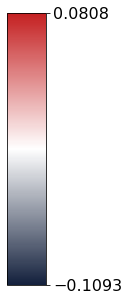

In [85]:
fig, ax = plt.subplots(figsize=(.7, 5))

create_colorbar(v_min_hm, v_max_hm, cmap=cmp, ax = ax, orientation='vertical')

# fig.savefig("gnn_pup_all_bw_cbar_t0vst12.png", dpi=1200, bbox_inches='tight')
# fig.savefig("gnn_pup_all_bw_cbar_t0vst12.svg", bbox_inches='tight')

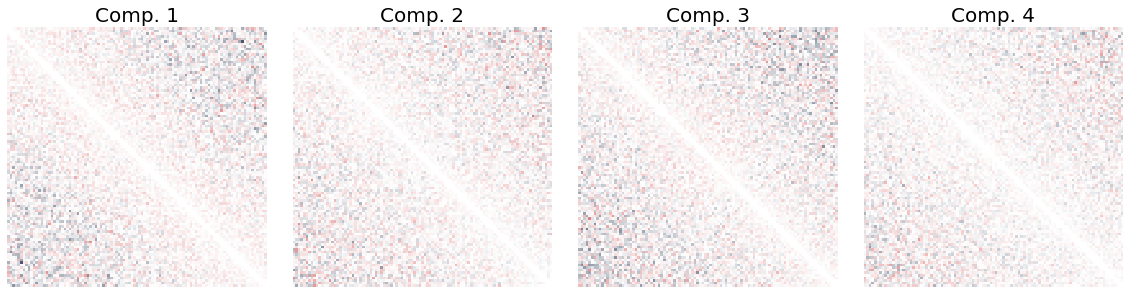

In [86]:
comp_0_12_vmin = -0.1438819131885209
comp_0_12_vmax = 0.12542265244318188

sigma = None

keys_row = {
    0: ['rep-eff-64', 'rep-eff-cpd'],
    #0: ['xr-64-over-sim', 'xr-cpd-over-sim'],
    1: ['ds-64-over-sim', 'ds-cpd-over-sim'],
}

row_names = {
    0: "Repair Efficiency",
    #0: "Normalized Repair levels",
    1: "Damage Sensitivity",
}

fig, ax = plt.subplots(
    1, 4,
    figsize=(20, 10), 
    sharex="row", sharey="row",
    # make ratios
    gridspec_kw={'hspace': 0.2, 'wspace': 0.1},
)

piles_divide_ = [np.log2(tup[1].data[0] / tup[0].data[0]) for tup in piles_]
#piles_divide_ = [tup[1].data[0] / tup[0].data[0] for tup in piles_]


v_min_hm = np.nanmin(np.concatenate(piles_divide_))
v_max_hm = np.nanmax(np.concatenate(piles_divide_))

oe_ss = "$ _{OE}$"

comp_names_easy = ["Comp. 1", "Comp. 2", "Comp. 3", "Comp. 4"]

comps_labes_now = [comps_labes[i] for i in range(0,8,2)]

cmp = LinearSegmentedColormap.from_list("custom_cmp", ["#14213D", "white", "#C42021"], N=256)
for i, pup in enumerate(piles_divide_):

    # continue # do not plot the heatmap

    ax_now = ax[i]
    # pup = pup[25:76, 25:76] # zoom in
    #sns.heatmap(pup, cmap=cmp, vmin=v_min_hm, vmax=v_max_hm, ax=ax_now, cbar=False, square=True, xticklabels=False, yticklabels=False, center=0)
    sns.heatmap(pup, cmap=cmp, vmin=comp_0_12_vmin, vmax=comp_0_12_vmax, ax=ax_now, cbar=False, square=True, xticklabels=False, yticklabels=False, center=0)

    # rect = patches.Rectangle((25, 25), 51, 51, linewidth=2, edgecolor='black', facecolor='none')
    # ax_now.add_patch(rect)
    # rect = patches.Rectangle((30, 30), 41, 41, linewidth=2, edgecolor='black', facecolor='none')
    # ax_now.add_patch(rect)
    ax_now.set_title(f"{comp_names_easy[i]}", fontsize=20)

plt.tight_layout()

# fig.savefig("gnn_pup_all_bw_t0vst12_noRepairShown.png", dpi=600, bbox_inches='tight')
# fig.savefig("gnn_pup_all_bw_t0vst12_noRepairShown.svg", bbox_inches='tight')

## Plot regions densities for all hi-c samples pairs

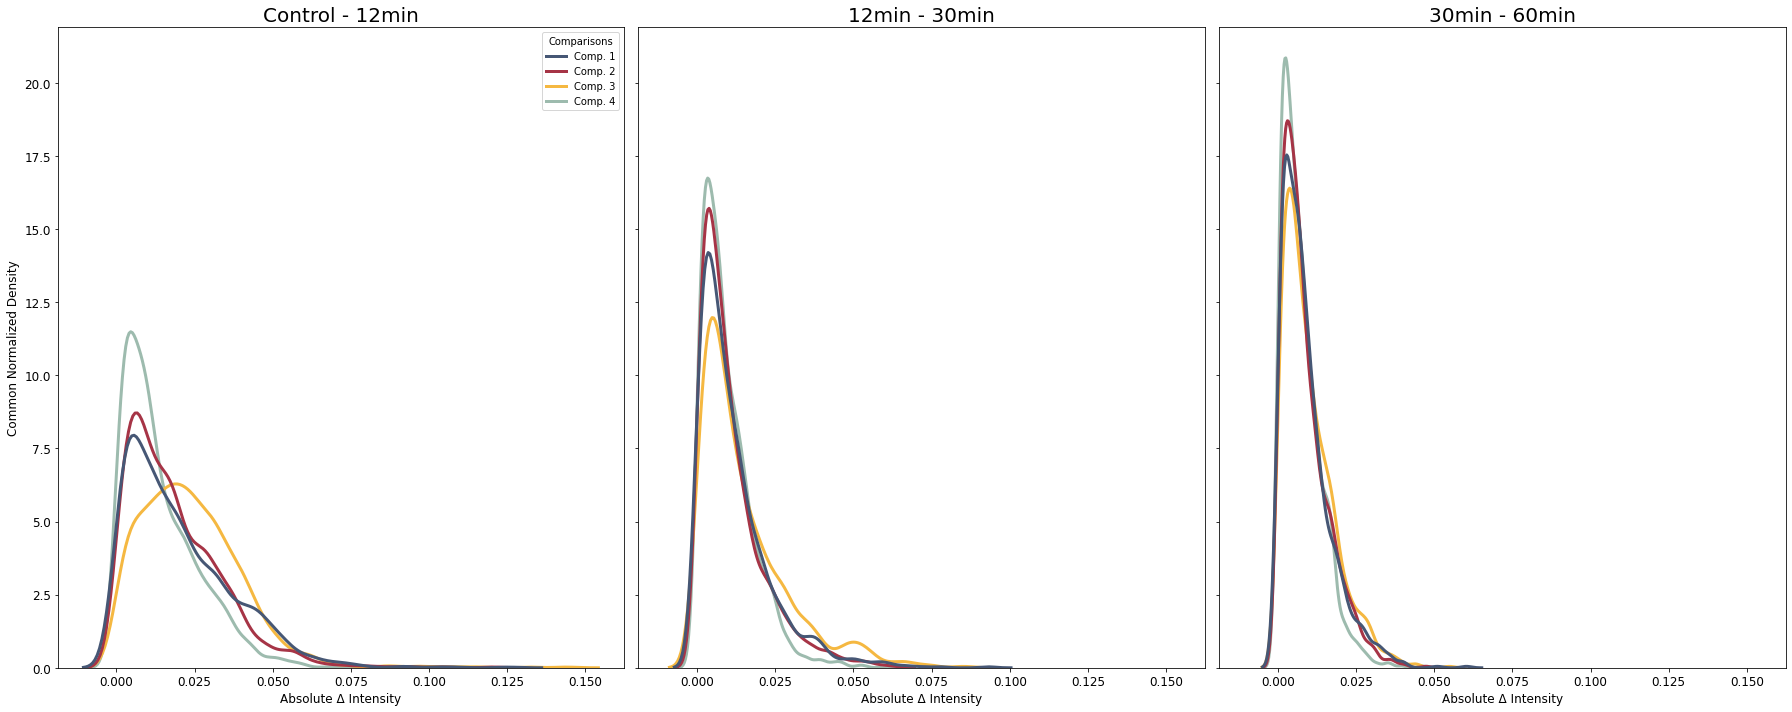

In [129]:
t0_t12 = pd.read_csv("/home/carlos/Desktop/manuscripts/notebooks/gnn/regions_change_density_t0vst12.tsv", sep="\t")
t0_t12['time'] = 'Control - 12min'

t12_t30 = pd.read_csv("/home/carlos/Desktop/manuscripts/notebooks/gnn/regions_change_density_t12vst30.tsv", sep="\t")
t12_t30['time'] = '12min - 30min'

t30_t60 = pd.read_csv("/home/carlos/Desktop/manuscripts/notebooks/gnn/regions_change_density_t30vst60.tsv", sep="\t")
t30_t60['time'] = '30min - 60min'

dfs = [t0_t12, t12_t30, t30_t60]

fig, ax = plt.subplots(1, 3, figsize=(25, 10), sharex=True, sharey=True)

for i, data in enumerate(dfs):
    s = sns.kdeplot(data = data, x="Changes", hue="Comparisons", fill=False, palette = ['#465775', '#A63446', '#F5B841', '#9DBBAE'], ax = ax[i], alpha=1, common_norm=True, linewidth=3)
    s.tick_params(axis='both', which='major', labelsize=12)
    s.tick_params(axis='both', which='minor', labelsize=12)
    s.set_xlabel(u"Absolute Δ Intensity", fontsize=12)
    s.set_ylabel(u"Common Normalized Density", fontsize=12)
    s.set_title(f"{data['time'].unique()[0]}", fontsize=20)
    if i != 0:
        s.get_legend().remove()

fig.tight_layout()
fig.savefig("regions_change_density_all.png", dpi=600, bbox_inches='tight')
fig.savefig("regions_change_density_all.svg", bbox_inches='tight')

## Plot 0-12, 12-30, 30-60

In [87]:
t30_t60_piles_divide_ = piles_divide_

In [60]:
t12_t30_piles_divide_ = piles_divide_

In [37]:
t0_t12_piles_divide_ = piles_divide_

In [88]:
all_vs_piles_divide_ = [t0_t12_piles_divide_, t12_t30_piles_divide_, t30_t60_piles_divide_]

In [95]:
sum([ratio*2, ratio, ratio, ratio*2, ratio*2])

1.0

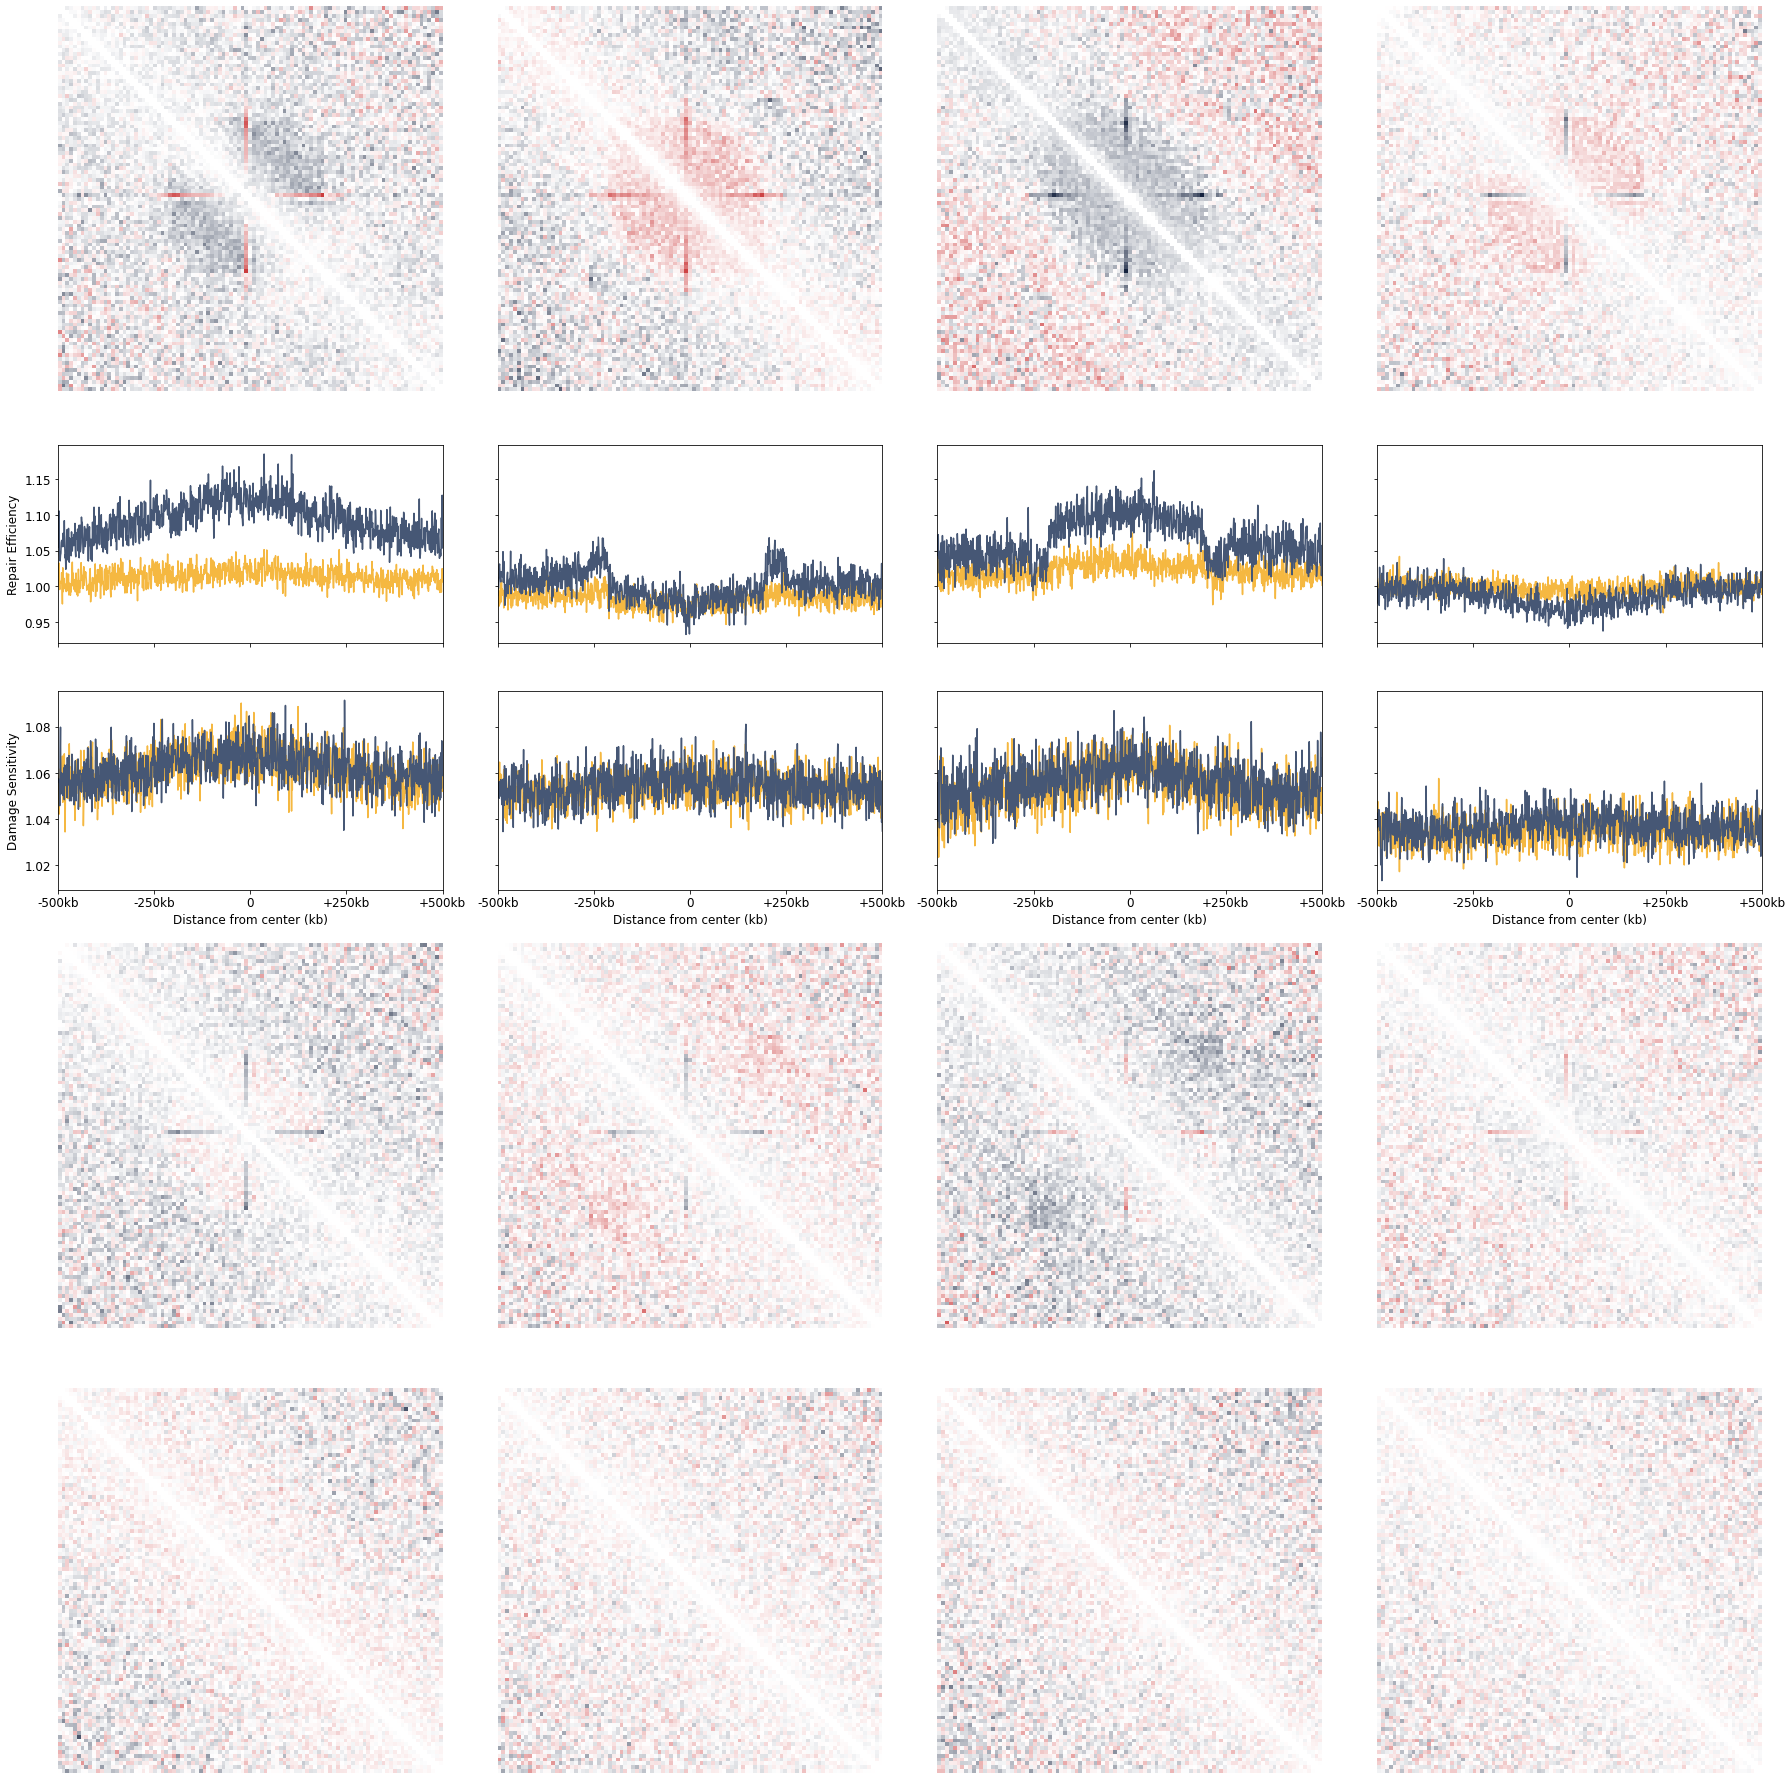

In [141]:
sigma = None

keys_row = {
    0: ['rep-eff-64', 'rep-eff-cpd'],
    #0: ['xr-64-over-sim', 'xr-cpd-over-sim'],
    1: ['ds-64-over-sim', 'ds-cpd-over-sim'],
}

row_names = {
    0: "Repair Efficiency",
    #0: "Normalized Repair levels",
    1: "Damage Sensitivity",
}

ratio=1/8

fig, ax = plt.subplots(
    len(keys_row)+3, 4,
    figsize=(25, 25), 
    sharex="row", sharey="row",

#    gridspec_kw={'height_ratios': [2,1,1,2,2], 'width_ratios': [1,1,1,1], 'hspace': 0.5, 'wspace': 0.1},
    gridspec_kw={'height_ratios': [2,1,1,2,2], 'width_ratios': [1,1,1,1]},

    #gridspec_kw={'hspace': 0.2, 'wspace': 0.1},

)

v_min_hm = np.nanmin(np.concatenate(t0_t12_piles_divide_))
v_max_hm = np.nanmax(np.concatenate(t0_t12_piles_divide_))

oe_ss = "$ _{OE}$"

comp_names_easy = ["Comp. 1", "Comp. 2", "Comp. 3", "Comp. 4"]

cmp = LinearSegmentedColormap.from_list("custom_cmp", ["#14213D", "white", "#C42021"], N=256)

for i, pup in enumerate(t0_t12_piles_divide_):
    ax_now = ax[0,i]
    sns.heatmap(pup, cmap=cmp, vmin=v_min_hm, vmax=v_max_hm, ax=ax_now, cbar=False, square=True, xticklabels=False, yticklabels=False, center=0)
    #ax_now.set_title(f"{comp_names_easy[i]}", fontsize=20)

for i, l in enumerate(bw_dict_all):    
    for k in range(len(keys_row)):
        
        ax_now = ax[k+1,i]
        
        l_now = {
            k_now: l[k_now] for k_now in keys_row[k]
        }

        armlabel=flank//1000
        
        bw_df = make_bw_df(l_now, sigma = sigma)

        lp = sns.lineplot(
            data=bw_df,
                x='n', 
                y='val',
                hue='name', 
                ax=ax_now,
                legend=True,
                #alpha=0.6,
                palette = ['#F5B841', '#465775'])
        
        end = bw_df['n'].max()
        lp.set_xticks([0, end//4, end//2, end//4*3, end])
        lp.set_ylabel(f"{row_names[k]}", fontsize=12)

        if k!=len(keys_row)-1:
            lp.set_xticklabels([])
            lp.set_xlabel("")
        else:
            lp.set_xticklabels([f"-{armlabel}kb", f"-{armlabel//2}kb", 0, f"+{armlabel//2}kb", f"+{armlabel}kb"], fontsize=12)
            lp.set_xlabel("Distance from center (kb)", fontsize=12)
            # rotate xlabels
            # for tick in lp.get_xticklabels():
            #     tick.set_rotation(15)

        ax_now.get_legend().remove()

        ax_now.tick_params(axis='both', which='major', labelsize=12)
        ax_now.tick_params(axis='both', which='minor', labelsize=12)

        ax_now.margins(x=0)

for i, pup in enumerate(t12_t30_piles_divide_):
    ax_now = ax[3,i]
    sns.heatmap(pup, cmap=cmp, vmin=v_min_hm, vmax=v_max_hm, ax=ax_now, cbar=False, square=True, xticklabels=False, yticklabels=False, center=0)
    #ax_now.set_title(f"{comp_names_easy[i]}", fontsize=20)

    
for i, pup in enumerate(t30_t60_piles_divide_):
    ax_now = ax[4,i]
    sns.heatmap(pup, cmap=cmp, vmin=v_min_hm, vmax=v_max_hm, ax=ax_now, cbar=False, square=True, xticklabels=False, yticklabels=False, center=0)
    #ax_now.set_title(f"{comp_names_easy[i]}", fontsize=20)


plt.tight_layout()

fig.savefig("gnn_pup_all_bw_all.png", dpi=600, bbox_inches='tight')
fig.savefig("gnn_pup_all_bw_all.svg", bbox_inches='tight')